In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices("GPU")
print("GPUs available:", gpus)

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


In [3]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        for img_name in os.listdir(label_path):
            img_path = os.path.join(label_path, img_name)
            try:
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
                img = tf.keras.preprocessing.image.img_to_array(img)
                images.append(img)
                labels.append(label)
            except:
                pass
    return np.array(images), np.array(labels)

train_dir = r'C:\Users\PRATHAM\Desktop\New folder\Alzheimer_s Dataset\train'
test_dir = r'C:\Users\PRATHAM\Desktop\New folder\Alzheimer_s Dataset\test1'

x_train, y_train = load_images_from_folder(train_dir)
x_test, y_test = load_images_from_folder(test_dir)

# Shuffle before augmentation split
shuffle_idx = np.random.permutation(len(x_train))
x_train = x_train[shuffle_idx]
y_train = y_train[shuffle_idx]

# Encode labels before using in generators
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

# 3. Data Augmentation
aug = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = aug.flow(x_train, y_train_cat, batch_size=8, subset='training')
val_generator = aug.flow(x_train, y_train_cat, batch_size=8, subset='validation')

x_test = x_test / 255.0


In [13]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/30
513/513 [==============================] - 36s 69ms/step - loss: 2.0685 - accuracy: 0.3041 - val_loss: 1.0639 - val_accuracy: 0.5342
Epoch 2/30
513/513 [==============================] - 35s 68ms/step - loss: 1.7951 - accuracy: 0.3788 - val_loss: 1.0468 - val_accuracy: 0.5635
Epoch 3/30
513/513 [==============================] - 35s 69ms/step - loss: 1.5494 - accuracy: 0.4362 - val_loss: 0.9683 - val_accuracy: 0.5781
Epoch 4/30
513/513 [==============================] - 36s 69ms/step - loss: 1.4779 - accuracy: 0.4559 - val_loss: 0.9511 - val_accuracy: 0.5781
Epoch 5/30
513/513 [==============================] - 35s 68ms/step - loss: 1.3822 - accuracy: 0.4786 - val_loss: 0.9177 - val_accuracy: 0.5820
Epoch 6/30
513/513 [==============================] - 35s 68ms/step - loss: 1.2975 - accuracy: 0.4852 - val_loss: 0.9005 - val_accuracy: 0.5938
Epoch 7/30
513/513 [==============================] - 35s 69ms/step - loss: 1.2448 - accuracy: 0.5057 - val_loss: 0.8654 - val_accuracy:

In [14]:
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
513/513 [==============================] - 45s 86ms/step - loss: 0.9550 - accuracy: 0.5477 - val_loss: 0.8938 - val_accuracy: 0.5801
Epoch 2/30
513/513 [==============================] - 44s 86ms/step - loss: 0.9559 - accuracy: 0.5497 - val_loss: 1.1213 - val_accuracy: 0.5635
Epoch 3/30
513/513 [==============================] - 44s 86ms/step - loss: 0.9299 - accuracy: 0.5719 - val_loss: 0.8349 - val_accuracy: 0.6338
Epoch 4/30
513/513 [==============================] - 44s 86ms/step - loss: 0.9023 - accuracy: 0.5741 - val_loss: 1.0403 - val_accuracy: 0.5283
Epoch 5/30
513/513 [==============================] - 44s 86ms/step - loss: 0.8604 - accuracy: 0.6000 - val_loss: 0.8402 - val_accuracy: 0.6045
Epoch 6/30
513/513 [==============================] - 44s 86ms/step - loss: 0.8595 - accuracy: 0.6117 - val_loss: 0.9137 - val_accuracy: 0.5859
Epoch 7/30
513/513 [==============================] - 44s 86ms/step - loss: 0.8135 - accuracy: 0.6297 - val_loss: 0.7531 - val_accuracy:


CNN Evaluation
                  precision    recall  f1-score   support

    MildDemented       1.00      0.85      0.92       179
ModerateDemented       1.00      1.00      1.00        12
     NonDemented       0.93      1.00      0.97       640
VeryMildDemented       0.97      0.93      0.95       448

        accuracy                           0.95      1279
       macro avg       0.97      0.94      0.96      1279
    weighted avg       0.95      0.95      0.95      1279



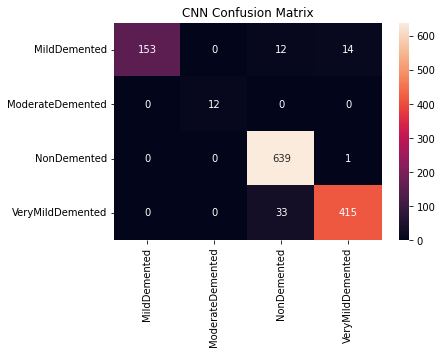

In [15]:
preds = model.predict(x_test)
preds_classes = np.argmax(preds, axis=1)

print("\nCNN Evaluation")
print(classification_report(y_test_enc, preds_classes, target_names=le.classes_))
cm = confusion_matrix(y_test_enc, preds_classes)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('CNN Confusion Matrix')
plt.show()


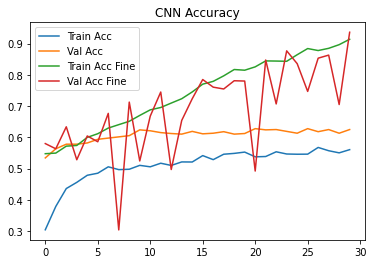

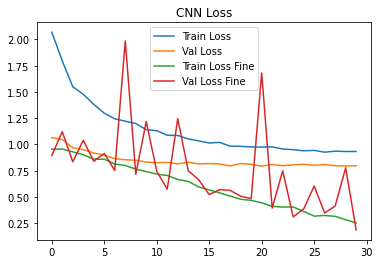

In [16]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.plot(fine_tune_history.history['accuracy'], label='Train Acc Fine')
plt.plot(fine_tune_history.history['val_accuracy'], label='Val Acc Fine')
plt.title('CNN Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.plot(fine_tune_history.history['loss'], label='Train Loss Fine')
plt.plot(fine_tune_history.history['val_loss'], label='Val Loss Fine')
plt.title('CNN Loss')
plt.legend()
plt.show()


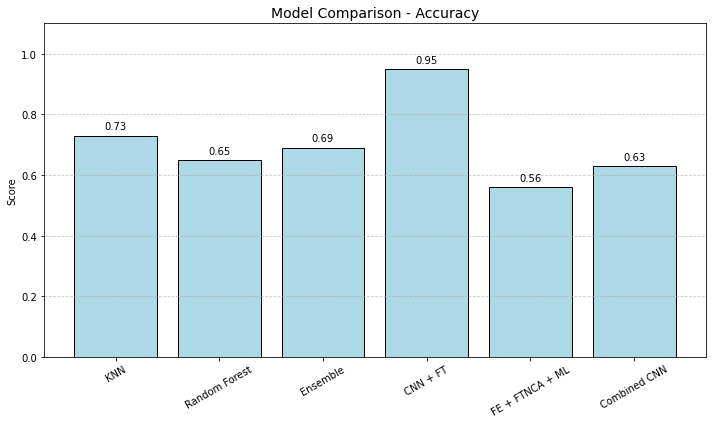

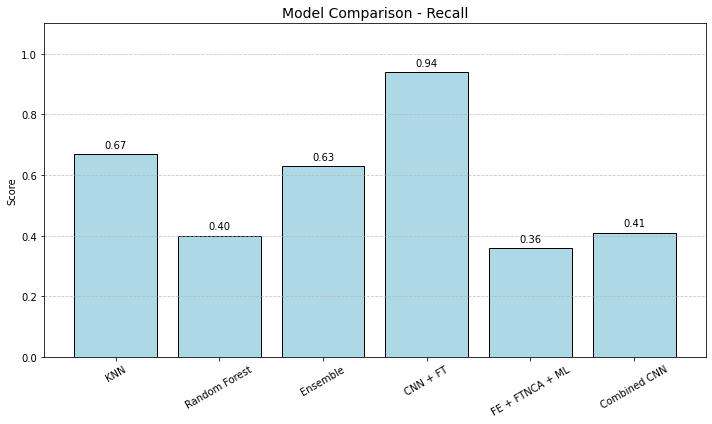

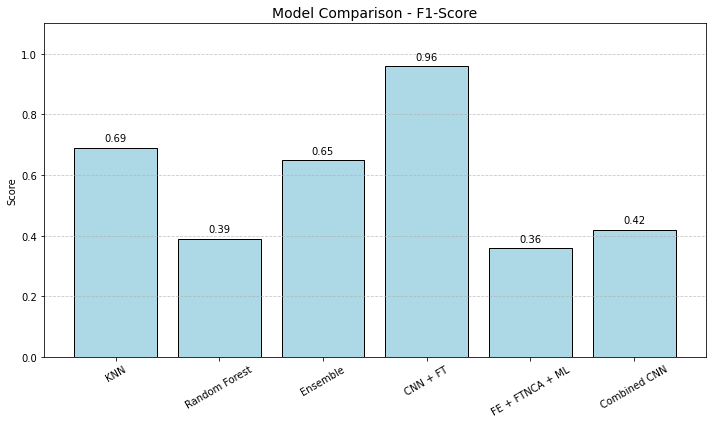

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = [
    "KNN", 
    "Random Forest", 
    "Ensemble", 
    "CNN + FT", 
    "FE + FTNCA + ML", 
    "Combined CNN"
]

# Metric values
accuracy = [0.73, 0.65, 0.69, 0.95, 0.56, 0.63]
recall = [0.67, 0.40, 0.63, 0.94, 0.36, 0.41]
f1_score = [0.69, 0.39, 0.65, 0.96, 0.36, 0.42]

def plot_bar(metric, title):
    plt.figure(figsize=(10, 6))
    bars = plt.bar(models, metric, color='lightblue', edgecolor='black')
    plt.ylim(0, 1.1)
    plt.title(title, fontsize=14)
    plt.ylabel('Score')
    plt.xticks(rotation=30)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}', ha='center', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_bar(accuracy, 'Model Comparison - Accuracy')
plot_bar(recall, 'Model Comparison - Recall')
plot_bar(f1_score, 'Model Comparison - F1-Score')


In [38]:
for layer in vgg16_base.layers:
    print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3


In [34]:
# Save the model as a .h5 file (recommended format for Keras models)
model.save('your_model.h5')  # Save model in HDF5 format
